# Import Libraries

In [44]:
import streamlit as st
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
import pickle
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error


# Import Files 

In [2]:
# Define the path to the directory containing the files
base_path = r"C:\Users\nandks\Case study"

# Define the list of file names for hbf and sb
hbf_files = [
    f'{base_path}\\freiburgambahnhof-2016.csv',
    f'{base_path}\\freiburgambahnhof-2017.csv',
    f'{base_path}\\freiburgambahnhof-2018.csv',
    f'{base_path}\\freiburgambahnhof-2019.csv',
    f'{base_path}\\freiburgambahnhof-2020.csv',
    f'{base_path}\\freiburgambahnhof-2021.csv'
]
sb_files = [
    f'{base_path}\\freiburgschlossberg-2016.csv',
    f'{base_path}\\freiburgschlossberg-2017.csv',
    f'{base_path}\\freiburgschlossberg-2018.csv',
    f'{base_path}\\freiburgschlossberg-2019.csv',
    f'{base_path}\\freiburgschlossberg-2020.csv',
    f'{base_path}\\freiburgschlossberg-2021.csv'
]

# Function to load and concatenate files
def load_and_concatenate(files):
    df_list = [pd.read_csv(file, header=None, names=["Date-Time", "Parking Spaces Available"]) for file in files]
    return pd.concat(df_list, ignore_index=True)

# Load the data
hbf = load_and_concatenate(hbf_files)
sb = load_and_concatenate(sb_files)

#hbf1 = hbf[hbf['Parking Spaces Available']<245]

print ("Note: Column names were added")

sb.head()


Note: Column names were added


,Date-Time,Parking Spaces Available
0,2016-06-21T08:05:46,290
1,2016-06-21T08:10:44,282
2,2016-06-21T08:15:09,269
3,2016-06-21T08:20:02,261
4,2016-06-21T08:25:04,259


# EDA + Initial Insights



In [3]:
#Check missing values 
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550203 entries, 0 to 550202
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Date-Time                 550203 non-null  object
 1   Parking Spaces Available  550203 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


In [4]:
#Check missing values 
hbf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550203 entries, 0 to 550202
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Date-Time                 550203 non-null  object
 1   Parking Spaces Available  550203 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


In [5]:
#Check distributions 
sb['Parking Spaces Available'].describe()

count    550203.000000
mean        294.263125
std         129.329071
min           0.000000
25%         204.000000
50%         349.000000
75%         398.000000
max         440.000000
Name: Parking Spaces Available, dtype: float64

In [6]:
#Check distributions 
hbf['Parking Spaces Available'].describe()

count    550203.000000
mean         98.813367
std          65.770878
min           0.000000
25%          51.000000
50%          97.000000
75%         147.000000
max         725.000000
Name: Parking Spaces Available, dtype: float64

##### There seems to be a a big difference between 75% and max for HBF

<Axes: >

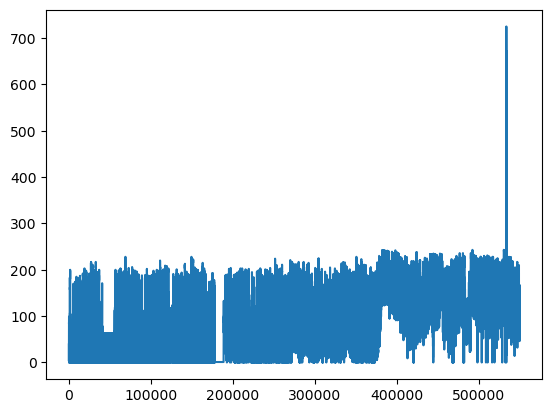

In [7]:
hbf['Parking Spaces Available'].plot()

<Axes: >

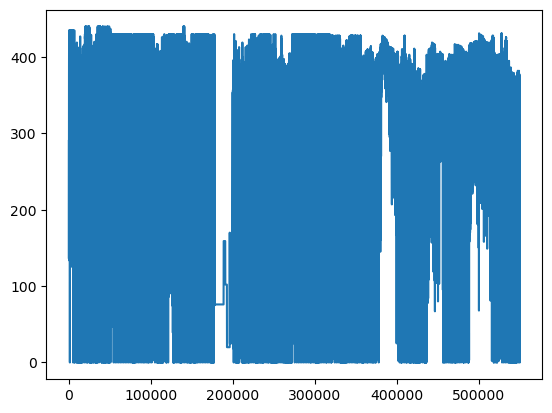

In [8]:
sb['Parking Spaces Available'].plot()

In [9]:
#Check which date is causing outlier 
outlier_date=hbf[hbf['Parking Spaces Available']>300]
outlier_date['Date-Time'] = pd.to_datetime(outlier_date['Date-Time'])
outlier_date['Date']=outlier_date['Date-Time'].dt.date
outlier_date['Date'].value_counts()

C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\1219134877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_date['Date-Time'] = pd.to_datetime(outlier_date['Date-Time'])
C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\1219134877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_date['Date']=outlier_date['Date-Time'].dt.date


2021-07-14    135
2021-07-15    117
Name: Date, dtype: int64

##### 15th and 16th July Seem to be outliers to HBF data 

# Data Preparation

In [10]:
def eda(df):
    df['Date-Time'] = pd.to_datetime(df['Date-Time'])

    # Extract Day
    df['Day'] = df['Date-Time'].dt.day
    df['Day'] = df['Day'].astype(str)

    # Extract Month
    df['Month'] = df['Date-Time'].dt.month
    df['Month'] = df['Month'].astype(str)

    # Extract Hour
    df['Hour'] = df['Date-Time'].dt.hour
    df['Hour'] = df['Hour'].astype(str)
    
    # Extract Minute
    df['Minute'] = df['Date-Time'].dt.minute
    df['Minute'] = df['Minute'].astype(str)

    # Extract Hour-Minute
    df['Hour-Minute'] = df['Hour'].astype(str) + '.' + df['Minute']
    df['Hour-Minute'] = df['Hour-Minute'].astype(float)
    
    # Extract Day of Week
    df['DOW'] = df['Date-Time'].dt.dayofweek
    df['DOW'] = df['DOW'].astype(str)
    
    # Extract Year
    df['Year'] = df['Date-Time'].dt.year

    # Weekend Flag
    df['Weekend Flag'] = df['Date-Time'].dt.weekday >= 5
    df['Weekend Flag'] = df['Weekend Flag'].astype(str)
    
    # Date
    df['Date'] = df['Date-Time'].dt.date
    
    #YMH 
    df['YMH'] = df['Year'].astype(str)+df['Month'].astype(str) + df['Hour'].astype(str)
    
     # Public Holiday in Freiburg, Germany
    de_holidays = holidays.Germany(state='BW')
    df['Public Holiday'] = df['Date-Time'].dt.date.apply(lambda x: x in de_holidays)
    df['Public Holiday'] = df['Public Holiday'].astype(str)
    #df = df.set_index('Date')
    
    return df

def feature_engineering(df):
    # Time of Day
    df['Time of Day'] = df['Hour'].astype(int).apply(lambda x: 'Morning' if 6 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Evening' if 18 <= x < 24 else 'Night')
    
    # Season based on Freiburg, Germany
    df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 
                                               'Spring' if x in [3, 4, 5] else 
                                               'Summer' if x in [6, 7, 8] else 
                                               'Autumn')
    
    # Hour-Minute Combined
    df['Hour-Minute Combined'] = df['Hour'].astype(int) + df['Minute'].astype(float) / 60
    
    # Create lag features
    df['Previous Hour Parking'] = df['Parking Spaces Available'].shift(1)
    df['Previous Day Parking'] = df['Parking Spaces Available'].shift(24)
    
    # Rolling statistics
    df['Rolling Mean 3 Hours'] = df['Parking Spaces Available'].rolling(window=3).mean()
    df['Rolling Median 7 Days'] = df['Parking Spaces Available'].rolling(window=24*7).median()
    
    # Interaction terms
    df['Hour_DOW'] = df['Hour'].astype(str) + '_' + df['DOW']
    df['Month_Public Holiday'] = df['Month'].astype(str) + '_' + df['Public Holiday']
    df['Weekend_Flag_Public_Holiday'] = df['Weekend Flag'].astype(str) + '_' + df['Public Holiday']
    
    return df

In [11]:
#Prepare hbf 
hbf_date = eda(hbf)
hbf_date = hbf_date[hbf_date['Parking Spaces Available']<243]
hbf_date['UR%'] = ((243-hbf_date['Parking Spaces Available'])/243)
hbf_date = feature_engineering(hbf_date)
hbf_date['Date'].value_counts()

C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\1576776022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hbf_date['UR%'] = ((243-hbf_date['Parking Spaces Available'])/243)
C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\4291811730.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time of Day'] = df['Hour'].astype(int).apply(lambda x: 'Morning' if 6 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Evening' if 18 <= x < 24 else 'Night')
C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\429

2018-02-15    291
2017-12-29    290
2017-06-09    290
2019-10-18    290
2017-03-08    289
             ... 
2021-02-05     49
2021-10-03     25
2016-08-18      5
2018-01-12      4
2018-01-20      1
Name: Date, Length: 1931, dtype: int64

In [12]:
#Evaluate hbf 
hbf_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549727 entries, 0 to 550202
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Date-Time                    549727 non-null  datetime64[ns]
 1   Parking Spaces Available     549727 non-null  int64         
 2   Day                          549727 non-null  object        
 3   Month                        549727 non-null  object        
 4   Hour                         549727 non-null  object        
 5   Minute                       549727 non-null  object        
 6   Hour-Minute                  549727 non-null  float64       
 7   DOW                          549727 non-null  object        
 8   Year                         549727 non-null  int64         
 9   Weekend Flag                 549727 non-null  object        
 10  Date                         549727 non-null  object        
 11  YMH                       

In [13]:
#Prepare sb 
sb_date = eda(sb)
sb_date['UR%'] = ((440-sb_date['Parking Spaces Available'])/440)
sb_date['Date'].value_counts()

2018-02-15    291
2017-06-09    290
2019-10-18    290
2017-12-29    290
2020-10-26    289
             ... 
2021-02-05     49
2021-10-03     25
2016-08-18      5
2018-01-12      4
2018-01-20      1
Name: Date, Length: 1931, dtype: int64

## Data Analysis

#### Some dates  have more data points than others 

In [14]:
hbf_date['Year'].value_counts()

2017    104921
2019    104814
2018    100379
2020     97391
2021     93406
2016     48816
Name: Year, dtype: int64

In [15]:
sb_date['Year'].value_counts()

2017    104921
2019    104814
2018    100379
2020     97391
2021     93882
2016     48816
Name: Year, dtype: int64

#### Some years have more data points than others, No years have the same data 


In [16]:
hbf_date['Minute'].value_counts()

55    44771
50    44719
35    44698
40    44632
45    44629
15    44523
5     44500
25    44430
30    44410
20    44308
10    44215
0     43920
1      1508
31     1068
26      999
11      972
6       936
21      876
16      866
51      837
41      836
46      827
56      802
36      792
12      313
27      307
7       276
32      274
2       256
22      249
47      234
17      229
42      224
52      210
37      209
57      205
13      129
14      124
24      123
8       102
23      102
29       96
44       86
38       81
3        70
28       68
39       58
9        57
59       56
49       56
33       53
54       50
19       50
18       50
53       48
48       44
34       44
58       44
43       43
4        33
Name: Minute, dtype: int64

# HBF 

In [17]:
#Parking space data points by year and DOW
hdf_pivot = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='DOW', 
                             columns='Year', 
                             aggfunc='count')
hdf_pivot


Year,2016,2017,2018,2019,2020,2021
DOW,,,,,,
0,6802,14945,14608,14884,13886,13374
1,7081,14964,14380,15258,13806,13450
2,7241,14892,14578,14897,13905,13315
3,7232,14948,14449,14901,13778,13340
4,6988,14975,14011,14974,13845,13504
5,6880,14957,14105,14974,14093,13316
6,6592,15240,14248,14926,14078,13107


In [18]:
#Max Parking spaces by Year and DOW
hdf_pivot = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='DOW', 
                             columns='Year', 
                             aggfunc='max')
hdf_pivot


Year,2016,2017,2018,2019,2020,2021
DOW,,,,,,
0,137,160,192,182,237,238
1,137,162,153,178,198,198
2,138,177,148,145,198,198
3,138,172,156,145,198,198
4,132,153,163,161,198,198
5,195,202,191,196,242,242
6,217,228,224,228,242,241


In [19]:
#Parking spaces data points by Year and hour
hdf_pivot = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='Hour', 
                             columns='Year', 
                             aggfunc='count')
hdf_pivot


Year,2016,2017,2018,2019,2020,2021
Hour,,,,,,
0,2015,4356,4154,4355,4053,3545
1,1996,4355,4154,4362,4054,3897
10,2035,4366,4185,4379,4030,3934
11,2047,4379,4189,4374,4023,3931
12,2049,4379,4178,4352,4039,3932
13,2070,4380,4180,4354,4056,3916
14,2072,4373,4178,4361,4060,3882
15,2043,4370,4172,4377,4063,3905
16,2025,4380,4174,4377,4067,3910


##### The hours and day of week have similar data per year 

<Axes: xlabel='DOW'>

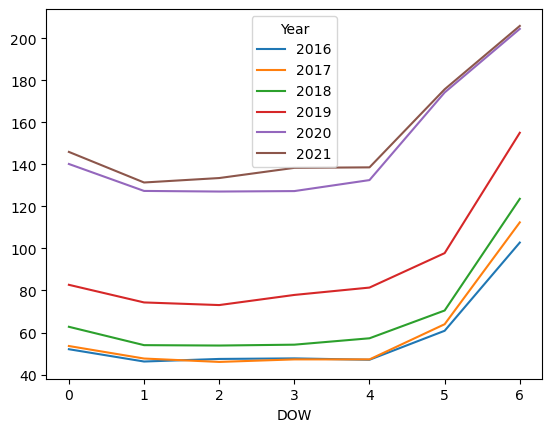

In [20]:
#Average Parking spaces by Year and DOW
hdf_pivot_mean = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='DOW', 
                             columns='Year', 
                             aggfunc='mean')
hdf_pivot_mean.plot()

### From the above plot it is clear that there is a weekend pattern but the number of parkings available seem to also be increasing by year

<Axes: xlabel='Hour'>

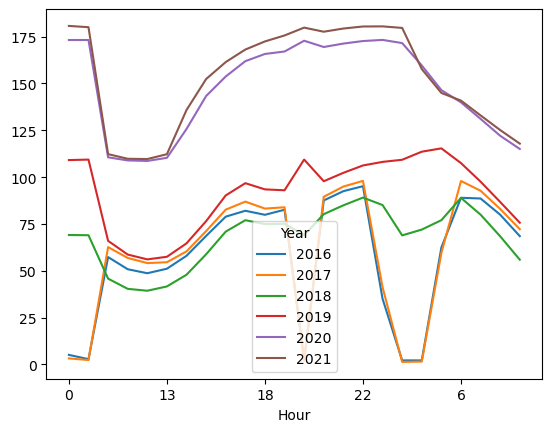

In [21]:
#Average Parking spaces by Year and hour

hdf_pivot_mean = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='Hour', 
                             columns='Year', 
                             aggfunc='mean')
hdf_pivot_mean.plot()


<Axes: xlabel='Hour'>

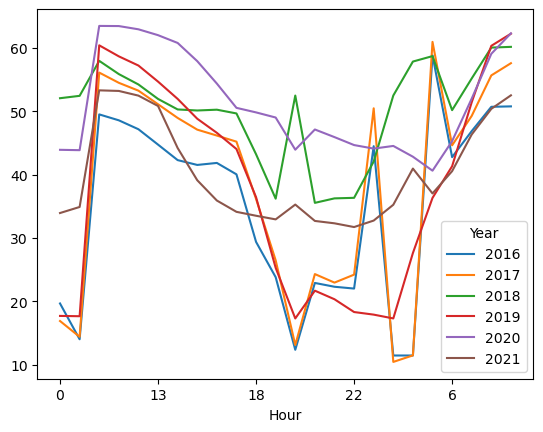

In [22]:
#Std Parking spaces by Year and hour
hdf_pivot_mean = pd.pivot_table(hbf_date, 
                             values='Parking Spaces Available', 
                             index='Hour', 
                             columns='Year', 
                             aggfunc='std')
hdf_pivot_mean.plot()


### 2016 and 2017 seem to have no availability before from 23pm to 5am

<Axes: xlabel='Hour'>

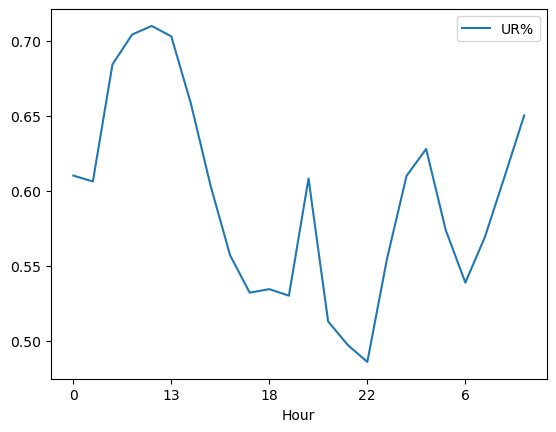

In [23]:
hbf_ut = hbf_date[['Hour','UR%']]
hbf_ut = hbf_ut.groupby('Hour').mean()
hbf_ut.plot()

# SB

<Axes: xlabel='DOW'>

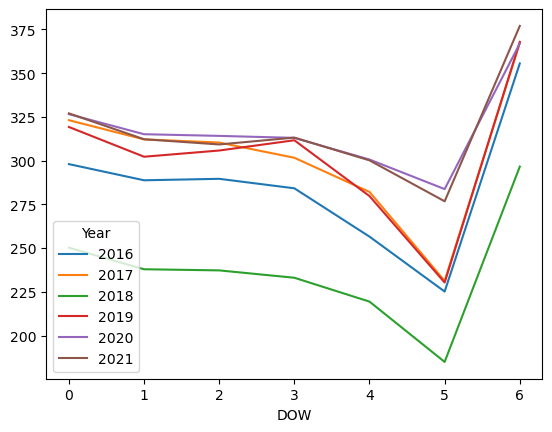

In [24]:
sb_pivot_mean = pd.pivot_table(sb_date, 
                             values='Parking Spaces Available', 
                             index='DOW', 
                             columns='Year', 
                             aggfunc='mean')
sb_pivot_mean.plot()

<Axes: xlabel='Hour'>

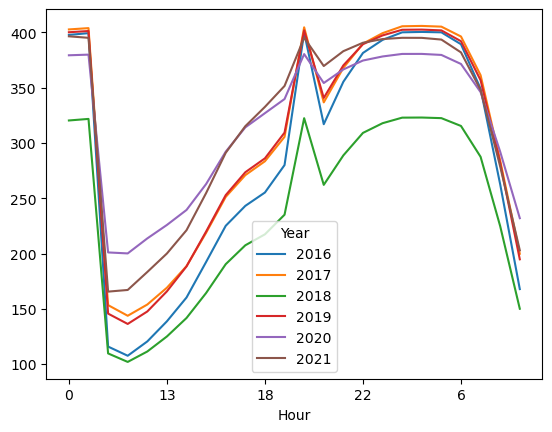

In [25]:
sb_pivot_mean = pd.pivot_table(sb_date, 
                             values='Parking Spaces Available', 
                             index='Hour', 
                             columns='Year', 
                             aggfunc='mean')
sb_pivot_mean.plot()


### The weekend pattern is observed and there seems to be a general increase by year, apart from 2018

In [26]:
hbf_date

,Date-Time,Parking Spaces Available,Day,Month,Hour,Minute,Hour-Minute,DOW,Year,Weekend Flag,...,Time of Day,Season,Hour-Minute Combined,Previous Hour Parking,Previous Day Parking,Rolling Mean 3 Hours,Rolling Median 7 Days,Hour_DOW,Month_Public Holiday,Weekend_Flag_Public_Holiday
0,2016-06-21 08:05:46,39,21,6,8,5,8.50,1,2016,False,...,Morning,Autumn,8.083333,NaN,NaN,NaN,NaN,8_1,6_False,False_False
1,2016-06-21 08:10:44,34,21,6,8,10,8.10,1,2016,False,...,Morning,Autumn,8.166667,39.0,NaN,NaN,NaN,8_1,6_False,False_False
2,2016-06-21 08:15:09,30,21,6,8,15,8.15,1,2016,False,...,Morning,Autumn,8.250000,34.0,NaN,34.333333,NaN,8_1,6_False,False_False
3,2016-06-21 08:20:02,29,21,6,8,20,8.20,1,2016,False,...,Morning,Autumn,8.333333,30.0,NaN,31.000000,NaN,8_1,6_False,False_False
4,2016-06-21 08:25:04,29,21,6,8,25,8.25,1,2016,False,...,Morning,Autumn,8.416667,29.0,NaN,29.333333,NaN,8_1,6_False,False_False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550198,2021-08-05 19:15:07,161,5,8,19,15,19.15,3,2021,False,...,Evening,Autumn,19.250000,161.0,87.0,161.000000,95.5,19_3,8_False,False_False
550199,2021-08-05 19:30:07,162,5,8,19,30,19.30,3,2021,False,...,Evening,Autumn,19.500000,161.0,82.0,161.333333,95.5,19_3,8_False,False_False
550200,2021-08-05 19:45:01,163,5,8,19,45,19.45,3,2021,False,...,Evening,Autumn,19.750000,162.0,78.0,162.000000,95.5,19_3,8_False,False_False
550201,2021-08-05 19:55:08,162,5,8,19,55,19.55,3,2021,False,...,Evening,Autumn,19.916667,163.0,78.0,162.333333,95.5,19_3,8_False,False_False


## UR analysis

C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\3503725157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hbf_ut.rename(columns={'UR%': 'UR%_HBF'}, inplace=True)
C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\3503725157.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sb_ut.rename(columns={'UR%': 'UR%_SB'}, inplace=True)


<Axes: title={'center': 'Comparision of UR% between HBF and SB'}, xlabel='Hour'>

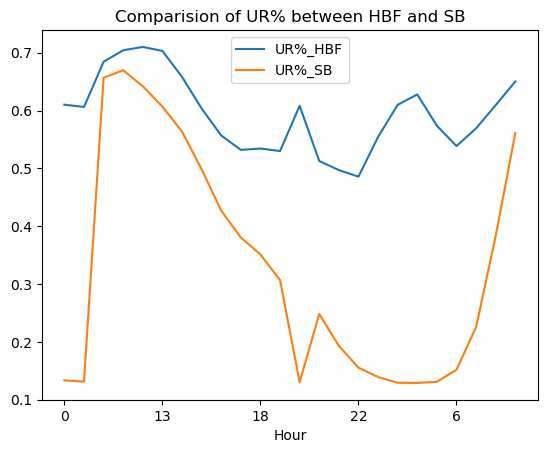

In [27]:
hbf_ut = hbf_date[['Hour','UR%']]
hbf_ut.rename(columns={'UR%': 'UR%_HBF'}, inplace=True)
hbf_ut = hbf_ut.groupby('Hour').mean()
sb_ut = sb_date[['Hour','UR%']]
sb_ut.rename(columns={'UR%': 'UR%_SB'}, inplace=True)
sb_ut = sb_ut.groupby('Hour').mean()
hs = hbf_ut.join(sb_ut,how='inner')
hs.plot(title = 'Comparision of UR% between HBF and SB')

## Model

In [30]:
# Split the dataframe
train_df = hbf_date[hbf_date['Year'] <= 2020]
#train_df = sb_date[sb_date['Year'] <= 2020]

#test_df = sb_date[sb_date['Year'] >= 2021]
test_df = hbf_date[hbf_date['Year'] >= 2021]

Mean Absolute Error: 21.465789077757783


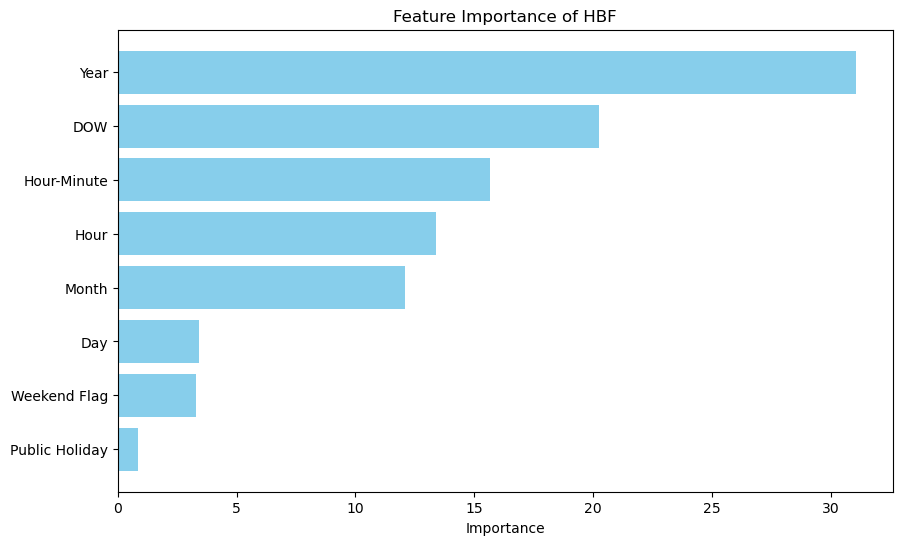

In [31]:
# Define features and target
features = ['Day', 'Month', 'Hour', 'Weekend Flag', 'Public Holiday', 'DOW', 'Hour-Minute', 'Year']
categorical_features = ['Day', 'Month', 'Hour', 'Weekend Flag', 'Public Holiday', 'DOW']
target = 'Parking Spaces Available'

# Convert the DataFrame to CatBoost Pool
train_pool = Pool(train_df[features], train_df[target], cat_features=categorical_features)
test_pool = Pool(test_df[features], test_df[target], cat_features=categorical_features)

# Initialize and train the model
model = CatBoostRegressor(verbose=0)
model.fit(train_pool)

# Make predictions
predictions = model.predict(test_pool)

# Calculate MAE
mae = mean_absolute_error(test_df[target], predictions)
print(f'Mean Absolute Error: {mae}')

# Extract feature importances
feature_importances = model.get_feature_importance(train_pool)

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance of HBF')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Error Analysis 

In [32]:
output = test_df.copy()

# Assuming 'date-time' and 'date' columns exist in test_df
output['actual'] = test_df[target]
output['predicted'] = predictions
output['absolute error'] = abs(output['actual'] - output['predicted'])
output['mean absolute error'] = mae

# Select relevant columns
output = output[['Date-Time', 'Date','Hour','actual', 'predicted', 'absolute error', 'mean absolute error']]
output

,Date-Time,Date,Hour,actual,predicted,absolute error,mean absolute error
456321,2021-09-09 12:55:01,2021-09-09,12,66,66.924903,0.924903,21.465789
456322,2021-09-09 13:00:01,2021-09-09,13,65,66.146739,1.146739,21.465789
456323,2021-09-09 13:05:02,2021-09-09,13,68,70.403357,2.403357,21.465789
456324,2021-09-09 13:10:02,2021-09-09,13,69,66.123797,2.876203,21.465789
456325,2021-09-09 13:15:02,2021-09-09,13,69,66.513220,2.486780,21.465789
...,...,...,...,...,...,...,...
550198,2021-08-05 19:15:07,2021-08-05,19,161,156.075303,4.924697,21.465789
550199,2021-08-05 19:30:07,2021-08-05,19,162,156.386261,5.613739,21.465789
550200,2021-08-05 19:45:01,2021-08-05,19,163,156.948200,6.051800,21.465789
550201,2021-08-05 19:55:08,2021-08-05,19,162,156.948200,5.051800,21.465789


<Axes: title={'center': 'Histogram of Absolute Error in HBF in 2022'}, ylabel='Frequency'>

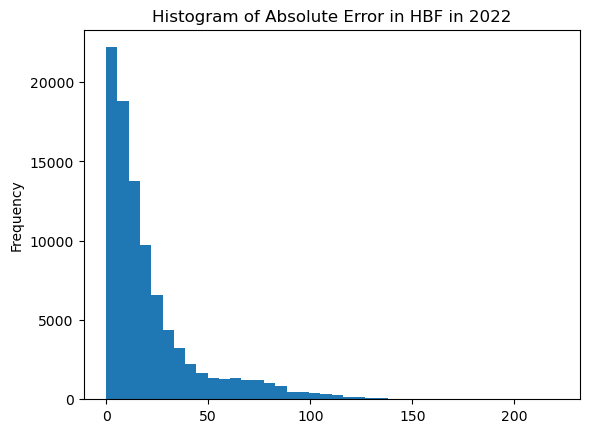

In [33]:
output['absolute error'].plot.hist(bins=40,title = 'Histogram of Absolute Error in HBF in 2022')

In [39]:
bd = output.groupby('Date').mean()
bd = bd[['absolute error']].sort_values(by='absolute error', ascending=True)
print('Best Predicted Days')
bd.head(10)

Best Predicted Days


C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\1214658697.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bd = output.groupby('Date').mean()


,absolute error
Date,
2021-05-23,3.858936
2021-04-04,3.918827
2021-11-26,4.108257
2021-05-30,4.154349
2021-06-27,4.259633
2021-05-16,4.575560
2021-04-11,4.690783
2021-04-18,4.743467
2021-08-08,4.927343


In [40]:
bd = output.groupby('Date').mean()
bd = bd[['absolute error']].sort_values(by='absolute error', ascending=True)
print('Worst Predicted Days')
bd.tail(10)

Worst Predicted Days


C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\2077453367.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bd = output.groupby('Date').mean()


,absolute error
Date,
2021-02-19,76.569136
2021-12-07,77.345638
2021-02-21,80.973734
2021-12-26,82.492892
2021-12-08,83.323806
2021-12-18,87.796530
2021-02-27,92.731155
2021-02-20,102.732463
2021-02-13,102.935361


C:\Users\nandks\AppData\Local\Temp\ipykernel_36216\198803298.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bd = output.groupby('Hour').mean()


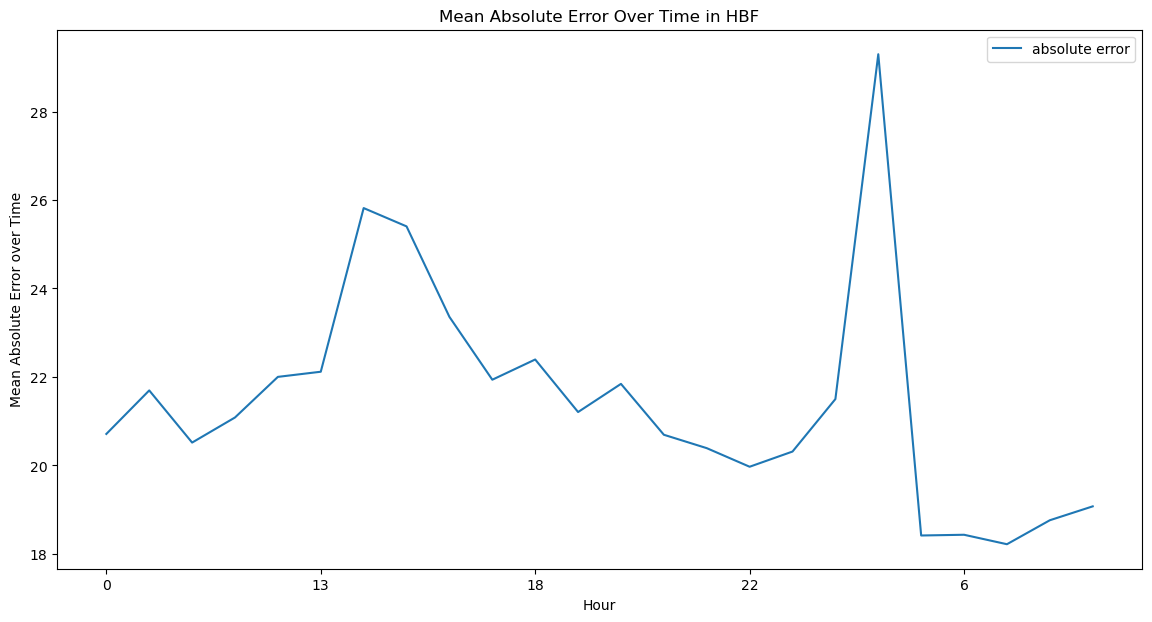

In [43]:
# Group by 'Date' and calculate the mean
bd = output.groupby('Hour').mean()

# Plot the 'absolute error' column with a wider figure
bd[['absolute error']].plot(figsize=(14, 7))  # Adjust the width and height as needed
plt.title('Mean Absolute Error Over Time in HBF')
plt.xlabel('Hour')
plt.ylabel('Mean Absolute Error over Time')
plt.show()


In [41]:
wd = bd.reset_index()
wd = wd[wd['Date'].astype(str)=='2021-12-19']
wd

,Date,absolute error
329,2021-12-19,104.316511


### Worse predicted days has only one data point in the day